# ImgLib2 

Example 08: Working with sparse data

## Introduction

ImgLib2 supports sparsely sampled data, i.e. collections of locations together with their value. Such datasets typically implement the [IterableRealInterval](http://javadoc.imagej.net/ImgLib2/net/imglib2/IterableRealInterval.html) interface, which means they can be iterated and have real-valued locations in n-dimensional space. Currently ImgLib2 supports to store such collections either as list ([RealPointSampleList](http://javadoc.imagej.net/ImgLib2/net/imglib2/RealPointSampleList.html)) or [KDTree](http://javadoc.imagej.net/ImgLib2/net/imglib2/KDTree.html). The [RealPointSampleList](http://javadoc.imagej.net/ImgLib2/net/imglib2/RealPointSampleList.html) can be iterated, whereas the [KDTree](http://javadoc.imagej.net/ImgLib2/net/imglib2/KDTree.html) additionally supports three efficient ways of searching for nearest neighboring points in the n-dimensional space ([NearestNeighborSearch](http://javadoc.imagej.net/ImgLib2/net/imglib2/neighborsearch/NearestNeighborSearch.html), [KNearestNeighborSearch](http://javadoc.imagej.net/ImgLib2/net/imglib2/neighborsearch/KNearestNeighborSearch.html), and [RadiusNeighborSearch](http://javadoc.imagej.net/ImgLib2/net/imglib2/neighborsearch/RadiusNeighborSearch.html)).

In order to display sparse data ImgLib2 currently supports two interpolation schemes, the [NearestNeighborInterpolation](http://javadoc.imagej.net/ImgLib2/net/imglib2/interpolation/randomaccess/NearestNeighborInterpolator.html) and the [InverseDistanceWeightingInterpolation](http://javadoc.imagej.net/ImgLib2/net/imglib2/interpolation/neighborsearch/InverseDistanceWeightingInterpolator.html). They can compute a value for every location in space by returning either the value of the closest sample or an interpolated, distance-weighted value of the k nearest neighbors to the sampled location. The interpolation scheme therefore converts any [IterableRealInterval](http://javadoc.imagej.net/ImgLib2/net/imglib2/IterableRealInterval.html) into a [RealRandomAccessible](http://javadoc.imagej.net/ImgLib2/net/imglib2/RealRandomAccessible.html) that can be displayed by wrapping it into a [RandomAccessible](http://javadoc.imagej.net/ImgLib2/net/imglib2/RandomAccessible.html) and defining [Interval](http://javadoc.imagej.net/ImgLib2/net/imglib2/Interval.html) using [Views](http://javadoc.imagej.net/ImgLib2/net/imglib2/view/Views.html).

*This is, however, not only useful for display. Note that you execute on such data any algorithm or method that is implemented for [RealRandomAccessible](http://javadoc.imagej.net/ImgLib2/net/imglib2/RealRandomAccessible.html) or [RandomAccessible](http://javadoc.imagej.net/ImgLib2/net/imglib2/RandomAccessible.html), like Gaussian convolution in the first example. **Note that none of these ever exists in memory, it is done completely virtual on just the sparse samples.***

## Example 8b - Randomly sample an existing image and display it

In this example we sample an existing image at random locations and render the result using a nearest neighbor interpolation as well as a distance-weighted average of the k nearest neighbors.

Below is the utility method for a given interval magnification.

In [1]:
import net.imglib2.Interval
import net.imglib2.RealInterval
import net.imglib2.RealPointSampleList
import net.imglib2.type.numeric.real.FloatType
import net.imglib2.type.numeric.RealType
import net.imglib2.RealPoint
import net.imglib2.RealRandomAccessible
import net.imglib2.type.Type
import net.imglib2.KDTree
import net.imglib2.RandomAccessibleInterval
import net.imglib2.neighborsearch.KNearestNeighborSearch
import net.imglib2.neighborsearch.KNearestNeighborSearchOnKDTree
import net.imglib2.neighborsearch.NearestNeighborSearchOnKDTree
import net.imglib2.interpolation.neighborsearch.InverseDistanceWeightingInterpolatorFactory
import net.imglib2.interpolation.neighborsearch.NearestNeighborSearchInterpolatorFactory
import net.imglib2.view.Views

obj = new Object() {
  /**
   * Sample a number of n-dimensional random points in a certain interval having a * random intensity 0...1
   *
   * @param interval - the interval in which points are created
   * @param numPoints - the amount of points
   *
   * @return a RealPointSampleList (which is an IterableRealInterval)
   */
  public <T extends Type<T>> RealPointSampleList<T> sampleRandomPoints(RealRandomAccessible<T> input, RealInterval interval, int numPoints) {
    // the number of dimensions
    numDimensions = interval.numDimensions()
    
    // a random number generator
    rnd = new Random(1332441549191l)
    
    // a list of Samples with coordinates
    elements = new RealPointSampleList<T>(numDimensions)
    
    // a random accessible in the image data to grep the right value
    realRandomAccess = input.realRandomAccess()
    
    for (int i = 0; i < numPoints; ++i) {
      point = new RealPoint( numDimensions)
      
      for (int d = 0; d < numDimensions; ++d) {
        point.setPosition(rnd.nextDouble() * (interval.realMax(d) - interval.realMin(d)) + interval.realMin(d), d)
      }
      
      realRandomAccess.setPosition(point)
      
      // add a new element with a random intensity in the range 0...1
      elements.add(point, realRandomAccess.get().copy())
    }
    return elements
  }
  
  /**
   * Sample randomly n points from the input and display the interpolated result using nearest neighbors
   *
   * @param input - the input data
   * @param interval - the size of the input (where to collect random samples)
   * @param numPoints - how many points to sample
   *
   * @return - a RandomAccessibleInterval of the same size as the input, rendered from the sparse data
   */
  public <T extends Type<T>> RandomAccessibleInterval<T> randomSampling(RealRandomAccessible<T> input, Interval interval, int numPoints) {
    // create an IterableRealInterval
    realInterval = sampleRandomPoints(input, interval, numPoints)
    
    // using nearest neighbor search we will be able to return a value an any position in space
    search = new NearestNeighborSearchOnKDTree<T>(new KDTree<T>(realInterval))
    
    // make it into RealRandomAccessible using nearest neighbor search
    realRandomAccessible = Views.interpolate(search, new NearestNeighborSearchInterpolatorFactory<T>())
    
    // convert it into a RandomAccessible which can be displayed
    randomAccessible = Views.raster(realRandomAccessible)
    
    // set the initial interval as area to view
    return Views.interval(randomAccessible, interval)
  }
  
   /**
    * Sample randomly n points from the input and display the interpolated result using
    * distance-weighted interpolation of 20 nearest neighbors
    *
    * @param input - the input data
    * @param interval - the size of the input (where to collect random samples)
    * @param numPoints - how many points to sample
    *
    * @return - a RandomAccessibleInterval of the same size as the input, rendered from the sparse data
    */
  public <T extends RealType<T>> RandomAccessibleInterval<T> randomSamplingKNearest(RealRandomAccessible<T> input, Interval interval, int numPoints) {
    // create an IterableRealInterval
    realInterval = sampleRandomPoints(input, interval, numPoints)
    
    // using nearest neighbor search we will be able to return a value an any position in space
    search = new KNearestNeighborSearchOnKDTree<T>(new KDTree<T> (realInterval), Math.min(20, (int)realInterval.size()))
    
    // make it into RealRandomAccessible using nearest neighbor search
    realRandomAccessible= Views.interpolate(search, new InverseDistanceWeightingInterpolatorFactory<T>())
    
    // convert it into a RandomAccessible which can be displayed
    randomAccessible = Views.raster(realRandomAccessible)
    
    // set the initial interval as area to view
    return Views.interval(randomAccessible, interval)
  }
}

Script1​$1​@154ab132

Working with sparse data, sample an existing image at random locations and render it again using an increasing number of samples.

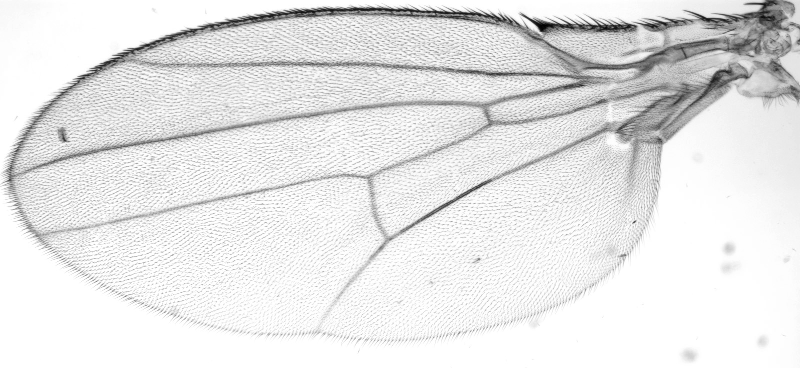

In [2]:
import net.imglib2.type.numeric.real.FloatType
import io.scif.img.ImgOpener

// open sample image with ImgOpener as FloatType
img = new ImgOpener().openImgs("http://samples.fiji.sc/tutorials/DrosophilaWing.tif", new FloatType()).get(0)

First we need to use linear interpolation to convert the input into a RealRandomAccessible.

In [3]:
import net.imglib2.type.numeric.real.FloatType
import net.imglib2.view.Views
import net.imglib2.interpolation.randomaccess.NLinearInterpolatorFactory

// use linear interpolation to convert the input into a RealRandomAccessible
realRandomAccessible = Views.interpolate(Views.extendMirrorSingle(img), new NLinearInterpolatorFactory<FloatType>())

net​.imglib2​.interpolation​.Interpolant​@73cfa7cc

 Then it shows the rendering using nearest neighbor interpolation.

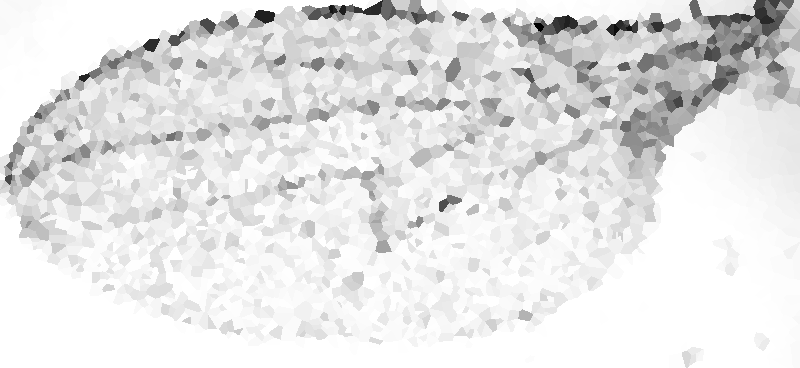

In [4]:
// You can change this variable to other number
numPoints = 4096
randomNNSample = obj.randomSampling(realRandomAccessible, img, numPoints)

At last it shows the result when use a distance weighted interpolation of the numPoints nearest neighbors.

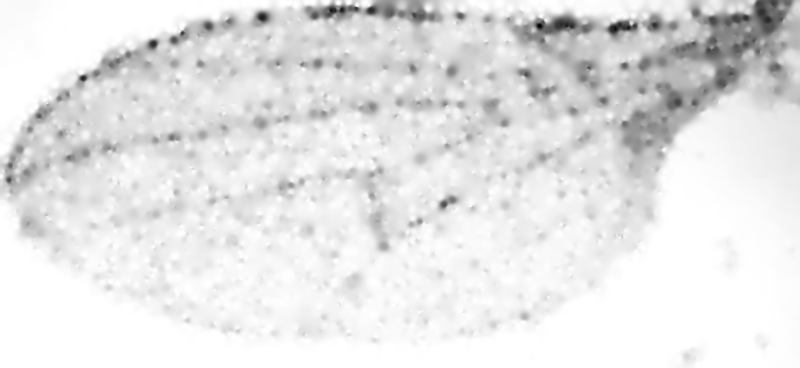

In [5]:
randomKNNSample = obj.randomSamplingKNearest(realRandomAccessible, img, numPoints)

You should notice the display and running time difference between nearest neighbor interpolation and distance weighted interpolation of k nearest neighbors.